# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the bootstrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# Print data sample
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [3]:
#Import modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

<h3>Question 1: Is the distribution of body temperatures normal?</h3>

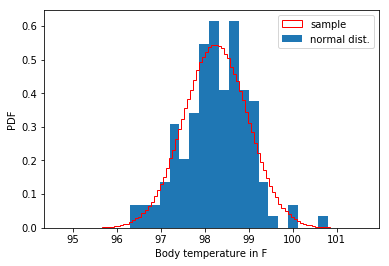

In [4]:
#Compute mean and standard deviation of temperature data
temp_mean=np.mean(df.temperature)
temp_std=np.std(df.temperature)

#Create samples of Normal distribution with temperature parameters
theo_norm=np.random.normal(temp_mean,temp_std,1000000)

#Plot temperature data histogram and normal distribution
_ = plt.hist(df.temperature, bins=20, density=True)
_ = plt.hist(theo_norm,bins=100,histtype='step',color='red',density=True)
_ = plt.ylabel('PDF')
_ = plt.xlabel('Body temperature in F')
_ = plt.legend(('sample','normal dist.'))
plt.show()

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n=len(data)

    # x-data for the ECDF: x
    x=np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

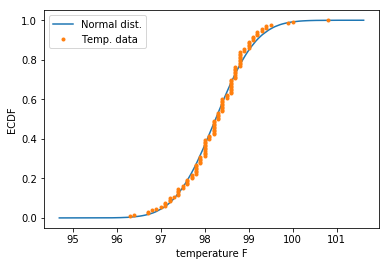

In [6]:
#Compute ecdf values for temperature data
x_temp,y_temp=ecdf(df.temperature)

#Compute ecdf values for equivalent normal distribution
x_theo,y_theo=ecdf(theo_norm)

#Plot ecdfs for both distributions
plt.plot(x_theo,y_theo)
plt.plot(x_temp,y_temp,marker='.',linestyle='none')

#Add labels
plt.ylabel('ECDF')
plt.xlabel('temperature F')
plt.legend(('Normal dist.','Temp. data'))

#Display plot
plt.show()

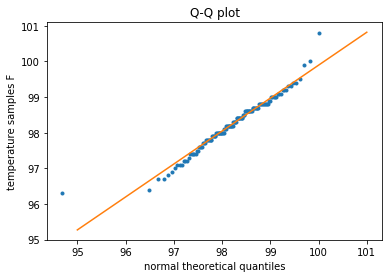

In [7]:
#Compute length of temperature series
n=len(df.temperature)

#Compute percentiles to be represented in the Q-Q plot
percentiles=[i/(n)*100 for i in range(n)]

#Sort temperature values in an array: temp_sorted
temp_sorted=df.temperature.sort_values().values

#Compute values of normal distribution related to computed percentiles
norm_values=np.percentile(theo_norm,percentiles)

#Compute slope and intercept of linear regression 
slope,intercept=np.polyfit(norm_values,temp_sorted,1)
points=np.array([95.0,101.0])

#Plot temperature vs. equivalent normal distribution percentiles: Q-Q plot
plt.plot(norm_values,temp_sorted,marker='.',linestyle='none')

#Plot linear regression
plt.plot(points,slope*points+intercept)

#Add labels and title
plt.ylabel('temperature samples F')
plt.xlabel('normal theoretical quantiles')
plt.title('Q-Q plot')
plt.show()

1. Is the distribution of body temperatures normal? 

The data fits pretty good the normal distribution in the ECDF plot.

Based on the Q-Q plot above, even though there are a few outliers, the data fits pretty good a line and therefore the body temperature has a normal distribution.

<h3>Question 2: Is the sample size large? Are the observations independent?</h3>

In [8]:
#Function that generates many bootstrap replicates from a data set
def draw_bs_reps(data, func, reps=1):
    
    # Initialize array of replicates: bs_replicates
    bs_replicates=np.empty(reps)
    
    # Generate replicates
    for i in range(reps):
        bs_replicates[i]=func(np.random.choice(data, size=len(data)))
        
    return bs_replicates

In order to check if the sample is large enough and the observations are independent, according to the central limit theorem (CLT) we can check if the arithmetic average of a sample taking a large number of samples of the data is normally distributed. 

Since we don't have the entire population, we will generate bootstrap replicates of the temperature data, computing the mean and check if they fit a normal distribution.

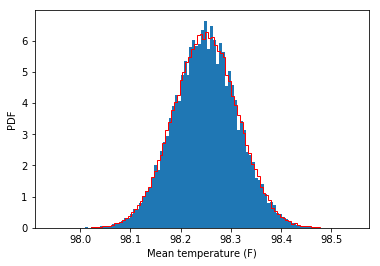

In [9]:
#Generate bootstrap replicates of the temperature data set
bs_replicates=draw_bs_reps(df.temperature,np.mean,reps=100000)

#Compute mean and standard deviation of bs_replicates 
bs_replicates_mean=np.mean(bs_replicates)
bs_replicates_std=np.std(bs_replicates)

#Generate normal distribution points with bs_replicates_mean and bs_replicates_std
theo_norm_replicates=np.random.normal(bs_replicates_mean,bs_replicates_std,100000)


#Plot bs_replicates
_ = plt.hist(bs_replicates, bins=100, density=True)

#Plot equivalent theoreritecal normal distribution
_ = plt.hist(theo_norm_replicates, bins=100, histtype='step', color='red', density=True)

#Add labels
_ = plt.ylabel('PDF')
_ = plt.xlabel('Mean temperature (F)')

plt.show()

2. Is the sample size large? Are the observations independent?

After generating several data samples and computing the mean for each of them, we see above that the means of the samples are normally distributed. We can assume that the observations are independent and that the sample size is large enough.

<h3>Question 3: Is the true population mean really 98.6 degrees F?</h3>

<h4>Bootstrap hypothesis test</h4>

We will try first a bootstrap hypothesis test. 

Null hypothesis: the true mean of the temperature data is 98.6 F, reported by Carl Wunderlich.

H0: μ=μ0

The test statistic is the difference between the data mean and Carl's value (98.6 F).

In [10]:
#Define Carl Wunderlich mean normal body temperature
bt_value=98.6

#Shift the temperature data so the new mean is 98.6F.
temp_shifted= df.temperature - temp_mean + bt_value

In [11]:
#Function to compute test statistic: difference between data mean and body normal temperature
def diff_from_bt(data, bt_value=98.6):
    return np.mean(data)-bt_value

In [12]:
#Difference from temperature data mean and Carl's number
diff_obs=diff_from_bt(df.temperature)
print('Mean temperature - 98.6 F: ',diff_obs,'F')

#Create bootstrap replicates of the shifted data
bs_replicates=draw_bs_reps(temp_shifted, diff_from_bt, reps=100000)

#Compute p-value
p_value=np.sum(bs_replicates<=diff_obs)/len(bs_replicates)
print('p-value: ',p_value)

Mean temperature - 98.6 F:  -0.35076923076921673 F
p-value:  0.0


Since the p value is really small, it is very unlikely that the true population mean is 98.6 F. The null hypothesis is rejected.

<h4>Frequentist statistical testing</h4>

One-sample test is used since we only have the dataset provided but not the data that Carl Wunderlich used to determine the value 98.6F.

In this particular case we will use t statistic since we don't know the variance of the population, we only know the mean.

We state our null and alternative hypothesis:

H0 : μ = 98.6 versus HA : μ ≠ 98.6

In [13]:
#Function to compute t-score
def t_score_from_bt(data,bt_value=98.6):
    return (np.mean(data)-bt_value)/(np.std(data)/(len(data)**0.5))

In [14]:
#Compute t-score of temperature data
t_score=t_score_from_bt(df.temperature)
print('t-score: ',t_score)

t-score:  -5.475925202078116


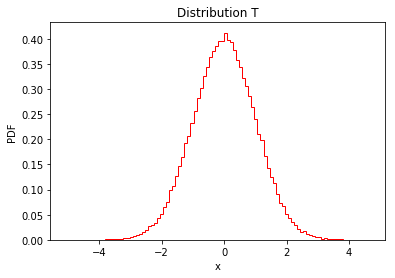

In [15]:
#Compute degrees of freedom in t-distribution
dof=len(df.temperature)-1

#Generate t-distribution
t_dist_values=np.random.standard_t(dof,size=100000)

#Plot t-distribution
plt.hist(t_dist_values,bins=100, histtype='step', color='red', density=True)

#Add labels
plt.ylabel('PDF')
plt.xlabel('x')
plt.title('Distribution T')
plt.show()

Since out hypothesis corresponds to a two-tailed test, there are two critical values to be computed:
    t(α/2, n - 1) and - t(α/2, n - 1)

We set our significance level α at 0.01

In [16]:
#Compute critical values: t(α/2, n - 1) and - t(α/2, n - 1)
critical_values_t=np.percentile(t_dist_values,[0.5,99.5])
print(critical_values_t)

[-2.62528751  2.61853385]


Since the t_score (-5.48) is smaller than our lower critical value, we reject the null hypothesis. It is very unlikely that normal body temperature is 98.6 F. 

In order to apply the z statistic test we would need to know the population standard deviation. Since we don't know it, we will use the sample one as an estimate.

In [17]:
#Compute z-score: the same as t_score since we are using the sample std as population std
#estimation

z_score=t_score
print('z-score: ',z_score)

z-score:  -5.475925202078116


In [18]:
#Compute critical values for a significance level of 0.01
critical_values_z=st.norm.ppf([0.005,0.995])
print(critical_values_z)

[-2.5758293  2.5758293]


Since the z_score (-5.48) is smaller than our lower z score critical value, we reject the null hypothesis. It is very unlikely that normal body temperature is 98.6 F. 

The same conclusion is reached both using t and z statistics. With a small sample size, we see that we reach to a different conclusion that if we use the whole dataset.

<h3>Question 4</h3>

In [19]:
#Draw a sample of 10 from the data
np.random.seed(20)
sample=np.random.choice(df.temperature,size=10)
print(sample)

[98.  98.8 98.8 98.6 97.7 98.7 98.4 97.8 98.3 96.7]


In [20]:
#Compute t-score of the sample
t_score_10=t_score_from_bt(sample)
print('t-score: ',t_score_10)

t-score:  -2.133326883375196


In [21]:
#Compute degrees of freedom in t-distribution
dof_10=len(sample)-1

#Compute t-scores for a significance level of 0.01
critical_values_z_10=st.t.ppf([0.005,0.995], dof)
print(critical_values_z_10)

[-2.61447868  2.61447868]


In [22]:
#Assuming that for the sample of size 10 this is all the information we have, 
#again z_score=t_score as we estimate the population std from the sample std
z_score_10=t_score_10
print('z-score: ',z_score_10)

z-score:  -2.133326883375196


In [23]:
#Compute z-scores for a significance level of 0.01
critical_values_z_10=st.norm.ppf([0.005,0.995])
print(critical_values_z_10)

[-2.5758293  2.5758293]


With a sample of 10, for both t and z statistic test we will accept the null hypothesis.

For small data samples (less than 30) the t statistic is the correct one. We observe that the z-scores are more restrictive than the t-scores, so that there are less chances to accept the null hypothesis.

<h3>Question 5: At what temperature should we consider someone's temperature to be "abnormal"?</h3>

Data is consider to be abnormal when it is an outlier, meaning when its distant from the mean is more than 3 standard deviations.

In [24]:
def confidence_interval(data,std_from_mean=3):
    return [np.mean(data)-3*np.std(data),np.mean(data)+3*np.std(data)]

In [25]:
#Compute confidence interval for normal data (no outliers)
sample_confidence_interval=confidence_interval(df.temperature)
print('Confidence interval of temperature data: ',sample_confidence_interval)

Confidence interval of temperature data:  [96.05815743251567, 100.44030410594588]


In [26]:
#Compute standard error of temperature data: se
se=temp_std/len(df.temperature)**0.5

#Critical value corresponding to outliers
critical_value=3

#Compute margin of error: me
me= critical_value*se
print('Margin of error: ',me)

#Temperature sample size
print('Temperature data size: ',len(df.temperature))

Margin of error:  0.19216984408558008
Temperature data size:  130


In [27]:
#Generate bootstrap replicates computing the upper and lower limit of the confidence interval
def draw_bs_ci_reps(data,reps=1):
    bs_replicates_upper=np.empty(reps)
    bs_replicates_lower=np.empty(reps)
    for i in range(reps):
            sample=np.random.choice(data, size=len(data))
            bs_replicates_lower[i]=np.mean(sample)-3*np.std(sample)
            bs_replicates_upper[i]=np.mean(sample)+3*np.std(sample)
    return bs_replicates_lower,bs_replicates_upper

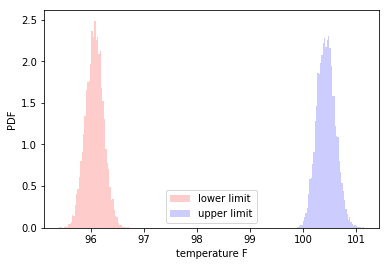

Lower limit 95% confidence interval:  [95.73736403 96.40532726]
Upper limit 95% confidence interval:  [100.1061801  100.77519014]


In [28]:
#Create bootstrap samples of confidence interval lower and upper limits
bs_replicates_lower, bs_replicates_upper= draw_bs_ci_reps(df.temperature,10000)

#Plot upper and lower limit distributions
plt.hist(bs_replicates_lower,bins=50,color='red',alpha=0.2, density=True)
plt.hist(bs_replicates_upper,bins=50,color='blue',alpha=0.2, density=True)
plt.title=('Limit normal values of temperature')
plt.legend(('lower limit','upper limit'))
plt.ylabel('PDF')
plt.xlabel('temperature F')
plt.show()

#95% confidence interval for lower limit
print('Lower limit 95% confidence interval: ',np.percentile(bs_replicates_lower,[2.5,97.5]))
#95% confidence interval for upper limit
print('Upper limit 95% confidence interval: ',np.percentile(bs_replicates_upper,[2.5,97.5]))

After computing both confidence intervals for the upper and lower limits we can consider a body temperature to be abnormal when it is higher than 100.77 F or lower than 95.74 F.

<h3>Question 6: Is there a significant difference between males and females in normal temperature?</h3>

Null hypothesis: the difference of mean temperature in males and females is zero.

H0: μf-μm=0

Ha: μf-μm≠0

We will use a permutation test to prove it. The permutation test is better for hypothesis test than bootstrapping. In this case we have 2 independent samples so we can perform the permutation test with no problem.

In [29]:
#Extract male temperatures: male_temp
male_temp=df[df.gender=='M'].temperature
#Extract female temperatures: female_temp
female_temp=df[df.gender=='F'].temperature

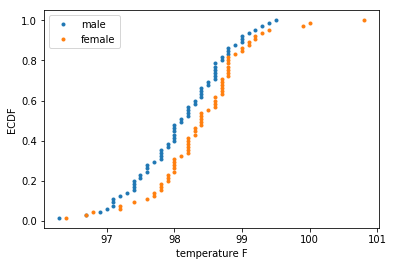

In [30]:
#Compute ecdf values from male and female temperatures
x_male,y_male=ecdf(male_temp)
x_female,y_female=ecdf(female_temp)

#Plot ecdf
plt.plot(x_male,y_male,marker='.',linestyle='none')
plt.plot(x_female,y_female,marker='.',linestyle='none')

#Add labels
plt.ylabel('ECDF')
plt.legend(('male','female'))
plt.xlabel('temperature F')
plt.show()

Based on the ECDF plot, it looks like women have higher body temperature than men.

In [31]:
#Generate a permutation sample
def permutation_sample(data):
    perm=np.random.permutation(data)
    data_1=perm[:int(len(data)/2)]
    data_2=perm[int(len(data)/2):]
    return data_1,data_2

#Generate permutation replicates
def draw_perm_reps(data,func,size=1):
    # Initialize array of replicates: perm_replicates
    perm_replicates=np.empty(size)
    
    for i in range(size):
        #Generate permutation sample
        perm_sample_1, perm_sample_2= permutation_sample(data)
    
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

#Compute difference of means
def diff_of_means(data_1,data_2):
    return np.mean(data_1)-np.mean(data_2)

In [32]:
#Compute empirical difference of means
empirical_diff_means=diff_of_means(male_temp,female_temp)
print('Empirical difference of means (male-female): ',empirical_diff_means)

#Draw 10,000 permutation replicates: perm_replicates
perm_replicates=draw_perm_reps(df.temperature,diff_of_means,size=10000)

#Compute p-value
p_value=np.sum(perm_replicates>=empirical_diff_means)/len(perm_replicates)
print('p-value: ',p_value)

Empirical difference of means (male-female):  -0.289230769230727
p-value:  0.9871


There is a 98.77% probability of observing a test statistic equally or more extreme than the one you observed, given that the null hypothesis is true. 

At a confidence level of 95%, provided that this is a two tailed test, the null hypothesis would be rejected. The p-value is higher than 97.5%. 

<h4>Conclusions</h4>

Based on the results of our test, we have rejected the null hypothesis at a 95% confidence level. This suggest that normal body temperature in men and woman is different. Based on this results, it might be worth it to reformulate the original question (What is the true normal human body temperature?) based on gender. 